In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from collections import defaultdict

base_folder = Path("../outputs/experiments/continual_learning").resolve()
cl_folder = base_folder / "continual_mitigation"

In [6]:
def load_results(folder):
    results = {}
    for path in folder.glob("*.csv"):
        df = pd.read_csv(path, index_col=0)
        if 'toxicity' in path.name:
            if 'groupby' in path.name:
                df = pd.read_csv(path, header=[0, 1], index_col=0)
                df = df.T.reset_index(names=["mode", "domain_result"]).melt(
                    id_vars=["mode", "domain_result"],
                    value_vars=["avg_max", "toxicity_probability", "std_max"],
                    var_name="metric"
                ).query("metric != 'std_max'")
                df["metric"] = df["metric"].map(
                    {"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"}
                )
                results['toxicity_gb'] = df.copy()
            else:
                df = df.reset_index().melt(
                    id_vars="index", value_name="value", var_name="mode"
                ).rename({'index': 'metric'}, axis=1).query("metric != 'std_max'").copy()

                df["metric"] = df["metric"].map(
                    {"avg_max": "Expected Maximum Toxicity", "toxicity_probability": "Toxicity Probability"}
                )
                results['toxicity'] = df.copy()
            
        else:
            df = df.melt(var_name="mode", value_name="value")

            if 'perplexity' in path.name:
                results['ppl'] = df.copy()
            elif 'diversity' in path.name:
                results['diversity'] = df.copy()
    return results

def get_metrics(exp_path, baseline=False):
    results_dfs = defaultdict(lambda: pd.DataFrame())

    if baseline:
        domain_results = load_results(exp_path)

        for rtp, results in zip([False], [domain_results]):
            for metric, df in results.items():
                df["domain"] = "baseline"
                df["domain_idx"] = -1
                df["RTP"] = rtp
                results_dfs[metric] = pd.concat([results_dfs[metric], df], axis=0).reset_index(drop=True)

        return results_dfs

    ds_added = [sub.name for sub in exp_path.iterdir()]
    for ds in ds_added:
        # TODO add this ds_added to the dataframe if required
        domains_folders = [sub.name for sub in sorted((exp_path / ds).iterdir()) if not 'logs' in sub.name]
        for domain_folder in domains_folders:
            idx, domain_name = domain_folder.split("=")[-1].split("-")        
            round_path = exp_path / ds / domain_folder

            domain_results = load_results(round_path)
            rtp_results = load_results(round_path / "RTP")

            for rtp, results in zip([False, True], [domain_results, rtp_results]):
                for metric, df in results.items():
                    df["domain"] = domain_name
                    df["domain_idx"] = int(idx)
                    df["RTP"] = rtp
                    results_dfs[metric] = pd.concat([results_dfs[metric], df], axis=0).reset_index(drop=True)

    return results_dfs

In [7]:
from itertools import permutations

#perms = ["".join(p) for p in permutations(["2", "4", "9"], 3)]
perms = ["clustered", "clustered/mixed_eval"]

metrics_df = defaultdict(lambda: pd.DataFrame())
for perm in perms:
    try:
        curr_metrics = get_metrics(cl_folder / perm / "gpt2-large/knn")
        for metric in curr_metrics.keys():
            curr_metrics[metric]["permutation"] = perm
            metrics_df[metric] = pd.concat([metrics_df[metric], curr_metrics[metric]])
    except FileNotFoundError:
        pass

## Toxicity

[]

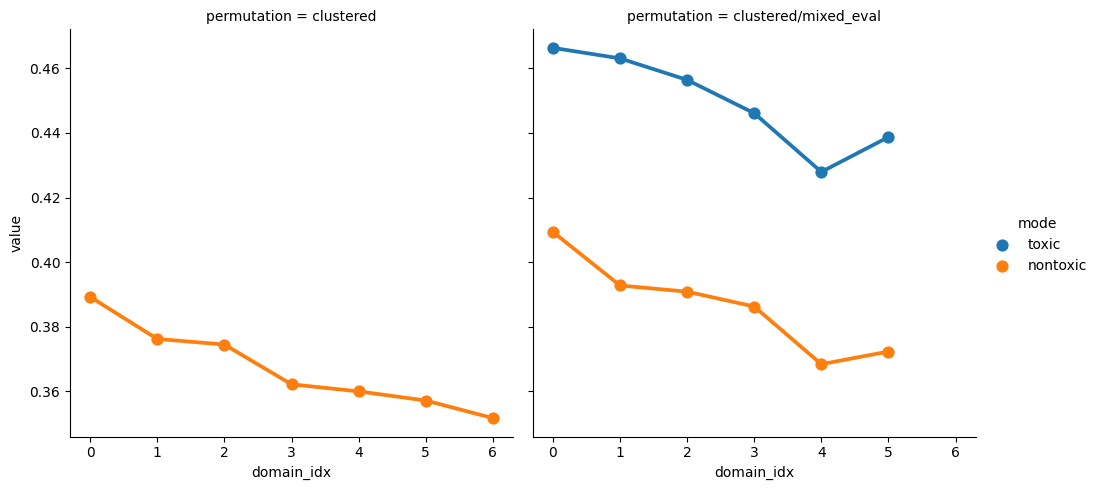

In [8]:
main_metric = "toxicity"
metric = "Expected Maximum Toxicity"

temp = metrics_df[main_metric].query("RTP == False and mode != 'full' and metric == @metric").copy()

sns.catplot(
    kind="point",
    data=temp,
    x="domain_idx",
    y="value",
    linestyles="-",
    hue="mode",
    col="permutation"
)

# plt.title(f"Overall {metric}")
plt.plot()

#### Domain-specific toxicity results

[]

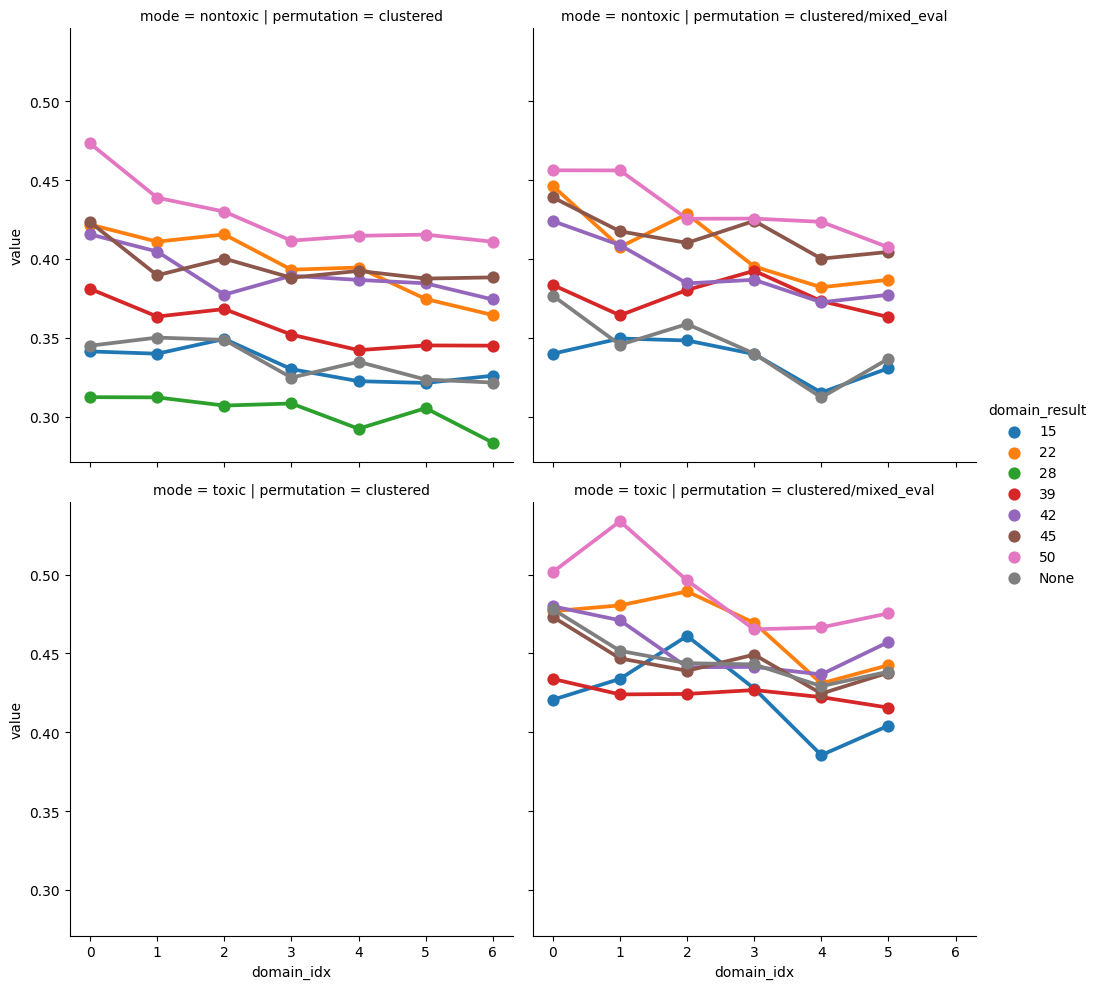

In [9]:
main_metric = "toxicity_gb"
metric = "Expected Maximum Toxicity"

temp = metrics_df[main_metric].query("RTP == False and mode != 'full' and metric == @metric").copy()

g = sns.catplot(
    data=temp,
    x="domain_idx",
    y="value",
    kind="point",
    hue="domain_result",
    col="permutation",
    row="mode"
)

#plt.suptitle(f"Domain-specific {metric}")
#plt.tight_layout()
plt.plot()